In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from math import pi

In [2]:
# Bokeh Library imports
import holoviews as hv
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.palettes import d3
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.transform import jitter
from bokeh.models import Range1d

output_notebook()

Loading BokehJS ...

## Read in the gapminder_clean.csv data as a pandas DataFrame.

In [3]:
# open gapminder dataset
data = pd.read_csv('gapminder_clean.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2607 entries, 0 to 2606
Data columns (total 20 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Unnamed: 0                                               2607 non-null   int64  
 1   Country Name                                             2607 non-null   object 
 2   Year                                                     2607 non-null   int64  
 3   Agriculture, value added (% of GDP)                      1428 non-null   float64
 4   CO2 emissions (metric tons per capita)                   2193 non-null   float64
 5   Domestic credit provided by financial sector (% of GDP)  1743 non-null   float64
 6   Electric power consumption (kWh per capita)              1369 non-null   float64
 7   Energy use (kg of oil equivalent per capita)             1410 non-null   float64
 8   Exports of goods and service

## Filter the data to include only rows where Year is 1962 and then make a scatter plot comparing 'CO2 emissions (metric tons per capita)' and gdpPercap for the filtered data.

In [4]:
# Filter data for the year 1962 and removing NaN values
filtered_data_1962 = data.loc[(data.Year == 1962)]

# Initialise Plot
plot = figure(plot_width = 600, plot_height = 600, y_axis_type='log', x_axis_type='log')

#Plot labels
plot.title = 'The Correlation Between CO2 Emissions and GDP per Capita in 1962'
plot.yaxis.axis_label = 'GDP per Capita'
plot.xaxis.axis_label = 'CO2 emissions (metric tons per capita)'


# Column Data Source
source = ColumnDataSource(data = {'emissions' : filtered_data_1962['CO2 emissions (metric tons per capita)'],
                                  'GDPpercap' : filtered_data_1962['gdpPercap'],
                                  'labels' : filtered_data_1962['Country Name']
                                 }
                         )

# Hover tool
hover = HoverTool(
        tooltips=[
            ("country", "@labels"),
            ("CO2 Emissions", "@emissions{0.00}"),
            ("GDP per Capita", "@GDPpercap{00.00}")
        ]
    )
                               

# Plot
plot.scatter('emissions', 'GDPpercap', size = 5, source=source)
plot.add_tools(hover)

show(plot)

## On the filtered data, calculate the pearson correlation of 'CO2 emissions (metric tons per capita)' and gdpPercap. What is the Pearson R value and associated p value?

In [5]:
# Pearsons Rank Correlation test
x = filtered_data_1962['CO2 emissions (metric tons per capita)'].notnull()
y = filtered_data_1962['gdpPercap'].notnull()
correlation, Pvalue = pearsonr(x, y)
print("Pearson's r: {corr} (p value: {p})".format(corr = correlation, p = Pvalue))

Pearson's r: 0.20821261671908833 (p value: 0.0007470994724147673)


## On the unfiltered data, answer "In what year is the correlation between 'CO2 emissions (metric tons per capita)' and gdpPercap the strongest?" Filter the dataset to that year for the next step...

In [6]:
# Correlator - collects emissions and gdp data for a given year and runs stats test returning results
def correlator(year, dataset):
    
    emissions = dataset.loc[(dataset.Year == year)].groupby('Year')['CO2 emissions (metric tons per capita)'].apply(np.asarray)
    gdp = dataset.loc[(dataset.Year == year)].groupby('Year')['gdpPercap'].apply(np.asarray)

    corr, p = pearsonr(*emissions, *gdp)
    
    return corr, p


# years data was collected stored as a list
years = sorted(data.Year.unique())

# remove NaN values from CO2 emmissions and GDP per cap
filtered_data = data.loc[data['CO2 emissions (metric tons per capita)'].notnull() & data['gdpPercap'].notnull()]


# Generate a dictionary of correlation and P-value by year
stat = {}
[stat.update({year: correlator(year, filtered_data)}) for year in years]


# Visualise dictionary as DataFrame ordered by R-value (descending order)
df = pd.DataFrame(stat).transpose()
df.rename(columns ={0:'R-value', 1:'P-value'}, inplace=True)
df.sort_values(by = 'R-value', ascending = False, inplace = True)
df

,R-value,P-value
1967,0.938792,3.397143e-53
1962,0.926082,1.128679e-46
1972,0.842899,1.824292e-32
1982,0.816638,5.565916e-29
1987,0.809553,3.899627e-28
1992,0.809432,1.610614e-29
1997,0.808140,7.976156e-30
2002,0.800642,3.863564e-29
1977,0.792834,2.838892e-26
2007,0.720417,9.232747e-22


## Using plotly or bokeh, create an interactive scatter plot comparing 'CO2 emissions (metric tons per capita)' and gdpPercap, where the point size is determined by pop (population) and the color is determined by the continent.

In [7]:
# Filter data for the year 1967 and remove NaN values
filtered_data_1967 = data[data.Year == 1967]
filtered_data_1967 = filtered_data_1967.dropna(how = 'any', subset = ['CO2 emissions (metric tons per capita)', 'gdpPercap'])
#filtered_data_1967 = filtered_data_1967[filtered_data_1967['Country Name'] != 'Kuwait']


# Intitialise Plot
plot = figure(plot_width = 750, plot_height = 750, y_axis_type='log', x_axis_type='log')
plot.xaxis.axis_label = 'CO2 emissions (metric tons per capita)'
plot.yaxis.axis_label = 'GDP per Capita'
plot.title = 'The Correlation between CO2 emissions and GDP per Capita in 1967'


#Data Source Column
source = ColumnDataSource(data = {'emissions' : filtered_data_1967['CO2 emissions (metric tons per capita)'],
                                  'GDPperCap' : filtered_data_1967['gdpPercap'],
                                  'countries' : filtered_data_1967['Country Name'], 
                                  'continent' : filtered_data_1967['continent'],
                                  'relative size' : (filtered_data_1967['pop']/filtered_data_1967['pop'].max())*500
                                 }
                         )


# Hover Tool 
hover = HoverTool(
        tooltips=[
            ("Country", "@countries"),
            ("CO2 Emissions", "@emissions{OO.OO}"),
            ("GDP per Capita", '@GDPperCap{OO.OO}')
        ]
    )


# Plot
plot.scatter('emissions', 'GDPperCap', 
             source = source,
             fill_color = factor_cmap('continent', 
             palette = d3['Category10'][5], 
            factors = filtered_data_1967['continent'].unique()),
            line_color = 'black',
            line_width = 0.75,
            size = 'relative size',
            legend_group = 'continent',
            )

plot.add_tools(hover)
plot.legend.location = 'top_left'
plot.legend.title = 'Continent'
plot.legend.title_text_font_style = "bold"
plot.legend.title_text_font_size = "20px"
plot.legend.label_text_font_size = "16px"


show(plot)

## Q1 What is the relationship between continent and 'Energy use (kg of oil equivalent per capita)'? (Stats test needed)

In [8]:
energy_data = data[data['Energy use (kg of oil equivalent per capita)'].notnull() & data['continent'].notnull()]

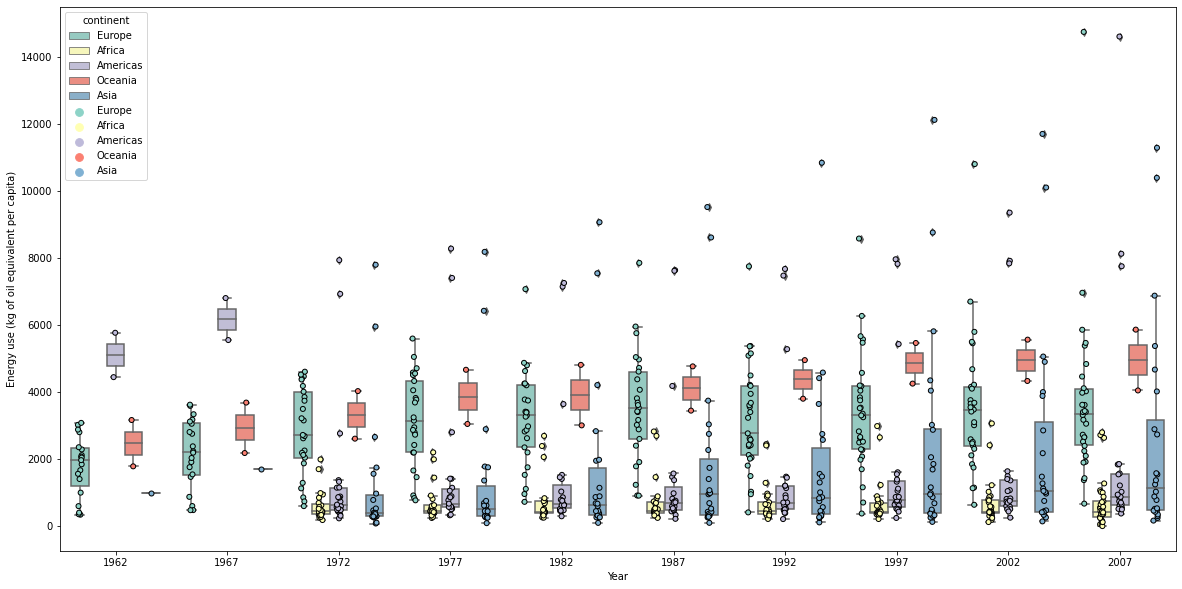

In [9]:
plt.figure(figsize=(20,10))

# Box plot of data
sns.boxplot(x="Year",
            y='Energy use (kg of oil equivalent per capita)',
            hue="continent",
            data=energy_data,
            palette="Set3")

# Stripplot of data
sns.stripplot(x="Year",
            y='Energy use (kg of oil equivalent per capita)',
            hue="continent",
            data=energy_data,
            palette="Set3",
            dodge=True,
            edgecolor='black', 
            linewidth=1,
             jitter=1)
    
plt.show()

In [10]:
energy_use = energy_data.groupby(['Year', 'continent'])['Energy use (kg of oil equivalent per capita)'].apply(np.asarray)
years = sorted(energy_data['Year'].unique())

# Run ANOVA of energy use by year of each continent and display DataFrame of F & P values
stat = {}
[stat.update({year: f_oneway(*energy_use[year])}) for year in years]
df = pd.DataFrame(stat, index = ['F-statistic', 'P-value'])
df.transpose()

,F-statistic,P-value
1962,8.737694,0.000664
1967,9.642467,0.000334
1972,7.366889,0.000036
1977,8.455679,0.000008
1982,7.551775,0.000027
1987,8.495935,0.000007
1992,7.897726,0.000015
1997,7.057320,0.000049
2002,6.637304,0.000090
2007,6.328448,0.000131


# Q2 Is there a significant difference between Europe and Asia with respect to 'Imports of goods and services (% of GDP)' in the years after 1990? (Stats test needed)



In [11]:
# Filter dataset for European and Asian countries after 1990
EuroAsiaImports = data.loc[(data.continent.isin(['Europe', 'Asia'])) & (data.Year >= 1990) & (data['Imports of goods and services (% of GDP)'].notnull())]

In [12]:
# Group imports by contient
stat_imports = EuroAsiaImports.groupby(['continent'])['Imports of goods and services (% of GDP)'].apply(np.asarray)


# Run unpaired t-test to compare imports GDP in asia and europe after 1990
corr, Pvalue = ttest_ind(*stat_imports)
print("Unpaired t-test: {corr} (p value: {Pvalue})".format(corr = corr, Pvalue = Pvalue))

Unpaired t-test: 1.4185256887958868 (p value: 0.15751969325554196)


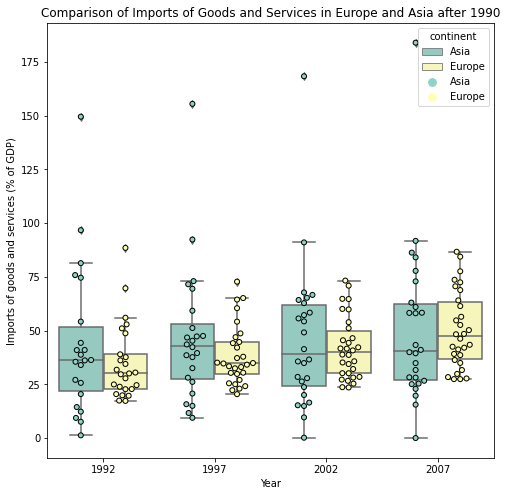

In [13]:
# Intialise plot
plt.figure(figsize=(8,8))
plt.title('Comparison of Imports of Goods and Services in Europe and Asia after 1990')

# box plot of data
sns.boxplot(x="Year", 
               y="Imports of goods and services (% of GDP)", 
               hue="continent", 
               data=EuroAsiaImports,
               palette="Set3")

# Swarm plot of data over violin
sns.swarmplot(x="Year", 
              y="Imports of goods and services (% of GDP)", 
              hue="continent", 
              edgecolor='black', 
              linewidth=1,
              dodge=True, 
              data=EuroAsiaImports,
              size=5, palette="Set3")

plt.show()

# Q3 What is the country (or countries) that has the highest 'Population density (people per sq. km of land area)' across all years? (i.e., which country has the highest average ranking in this category across each time point in the dataset?)

# Q4 What country (or countries) has shown the greatest increase in 'Life expectancy at birth, total (years)' since 1962?

In [36]:
# Filter Null values
life = data.loc[data['Life expectancy at birth, total (years)'].notnull()]


# Group by country and life expectancy and make DataFrame
a = life.groupby('Country Name')['Life expectancy at birth, total (years)'].apply(np.asarray)
df_le = pd.DataFrame(a)


# Find earliest and latest Life expactancy
low = [df_le.loc[country][0][0] for country in life['Country Name'].unique()]
high = [df_le.loc[country][0][-1] for country in life['Country Name'].unique()]


# Generate DataFrame of earliest and latest Life expactancy
df = pd.DataFrame({'country' : life['Country Name'].unique(),
              'low' : low,
              'high' : high,
              'low_year': low_year,
              'high_year' : high_year})


# Calculate absolute and percentaeg differnce in Life Expectancy - Rank by percentage difference
df['absdiff'] = df['high']-df['low']
df['percentagediff'] = (df['high']-df['low'])/(df['low'])*100
df['rank'] = df['percentagediff'].rank(ascending = False)

In [37]:
# Columnn Data Source
source = ColumnDataSource(data = {'Country' : df['country'],
                                  'Initial' : df['low'],
                                  'Final' : df['high'],
                                  'percentage' : df['percentagediff'],
                                  'rank' : df['rank'],
                                  'low_year': df['low_year'],
                                  'high_year' : df['high_year']
                                 }
                         )


#Hover Tool
hover = HoverTool(
        tooltips=[('Country', '@Country'),
                  ('Rank', '@rank'),
                  ('Percentage Change', '@percentage{OO.OO}%'),
                  ('Change in Life Expectancy', '@Initial{00.0O} -> @Final{00.0O}'),
                  ('Time Period', '@low_year -> @high_year')
                  
                 ]
)

#Initialise Plot
plot = figure(plot_height=600, plot_width = 2500, x_range=df['country'])
plot.xaxis.major_label_orientation = pi/2
plot.xaxis.axis_label = 'Country'
plot.yaxis.axis_label = 'Percentage Difference in Life Expectancy (Years)'

# Bar chart
plot.vbar(x='Country', top='percentage', source=source, width = 0.75)
plot.add_tools(hover)
show(plot)